<a href="https://colab.research.google.com/github/Kekoez/Funji-BOT/blob/main/Project_Typhoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook wandb
import fastbook

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from plotnine import *
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/Mushroom ')

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(256, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=256, flip_vert=True,),
    )
dls = dblock.dataloaders(path, bs=45)

In [ ]:
# set seed for reproducability
set_seed(4,True)
dls.rng.seed(4)

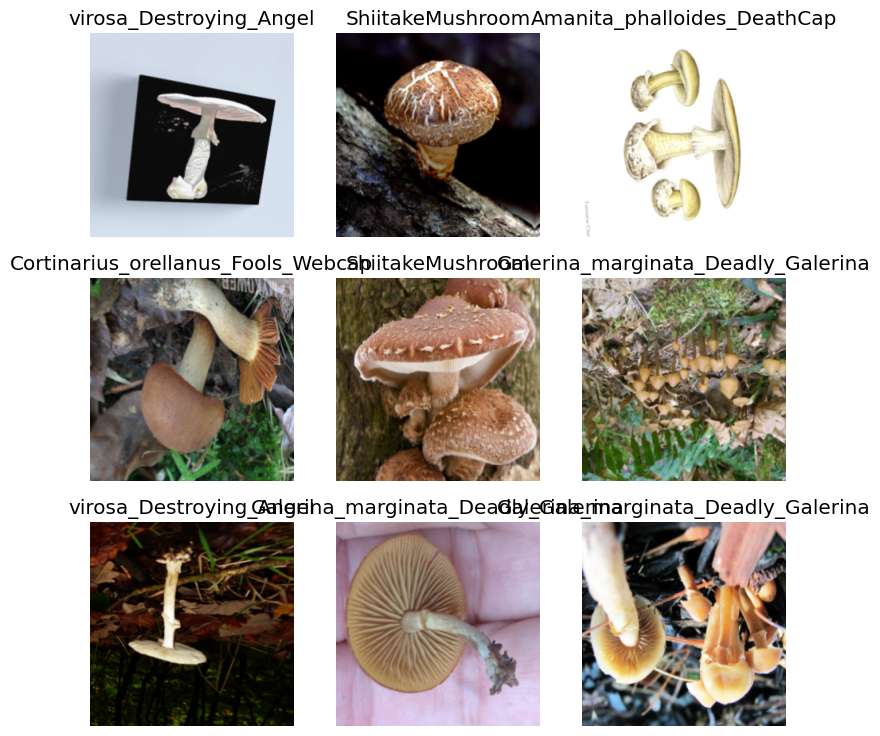

In [ ]:
dls.train.show_batch(max_n=9, nrows=3)

In [ ]:
from fastai.learner import *

In [ ]:
# import torchvision.models as models
# mobilenet = models.mobilenet_v2(pretrained=True)
# def _mobilenet_v2_split(m:nn.Module): return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)
# _mobilenet_v2_meta   = {'cut':-1, 'split':_mobilenet_v2_split, 'stats':imagenet_stats}
# model_meta[models.mobilenet_v2] = {**_mobilenet_v2_meta}

In [ ]:
learn = cnn_learner(dls,
                      resnet50,
                    metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')]).to_fp16()

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


In [ ]:
learn.fine_tune(epochs=5,
          base_lr=1e-3, #max lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.236550,1.099123,0.717228,0.722610,0.717228,0.713259,01:19


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.246283,1.099404,0.717228,0.721739,0.717228,0.714568,01:17
1,0.266933,1.269190,0.711610,0.725061,0.711610,0.707857,01:22
2,0.261155,1.195101,0.713483,0.720772,0.713483,0.707859,01:19
3,0.236749,1.171644,0.722846,0.734021,0.722846,0.720440,01:19
4,0.206238,1.160348,0.730337,0.738883,0.730337,0.728851,01:19


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

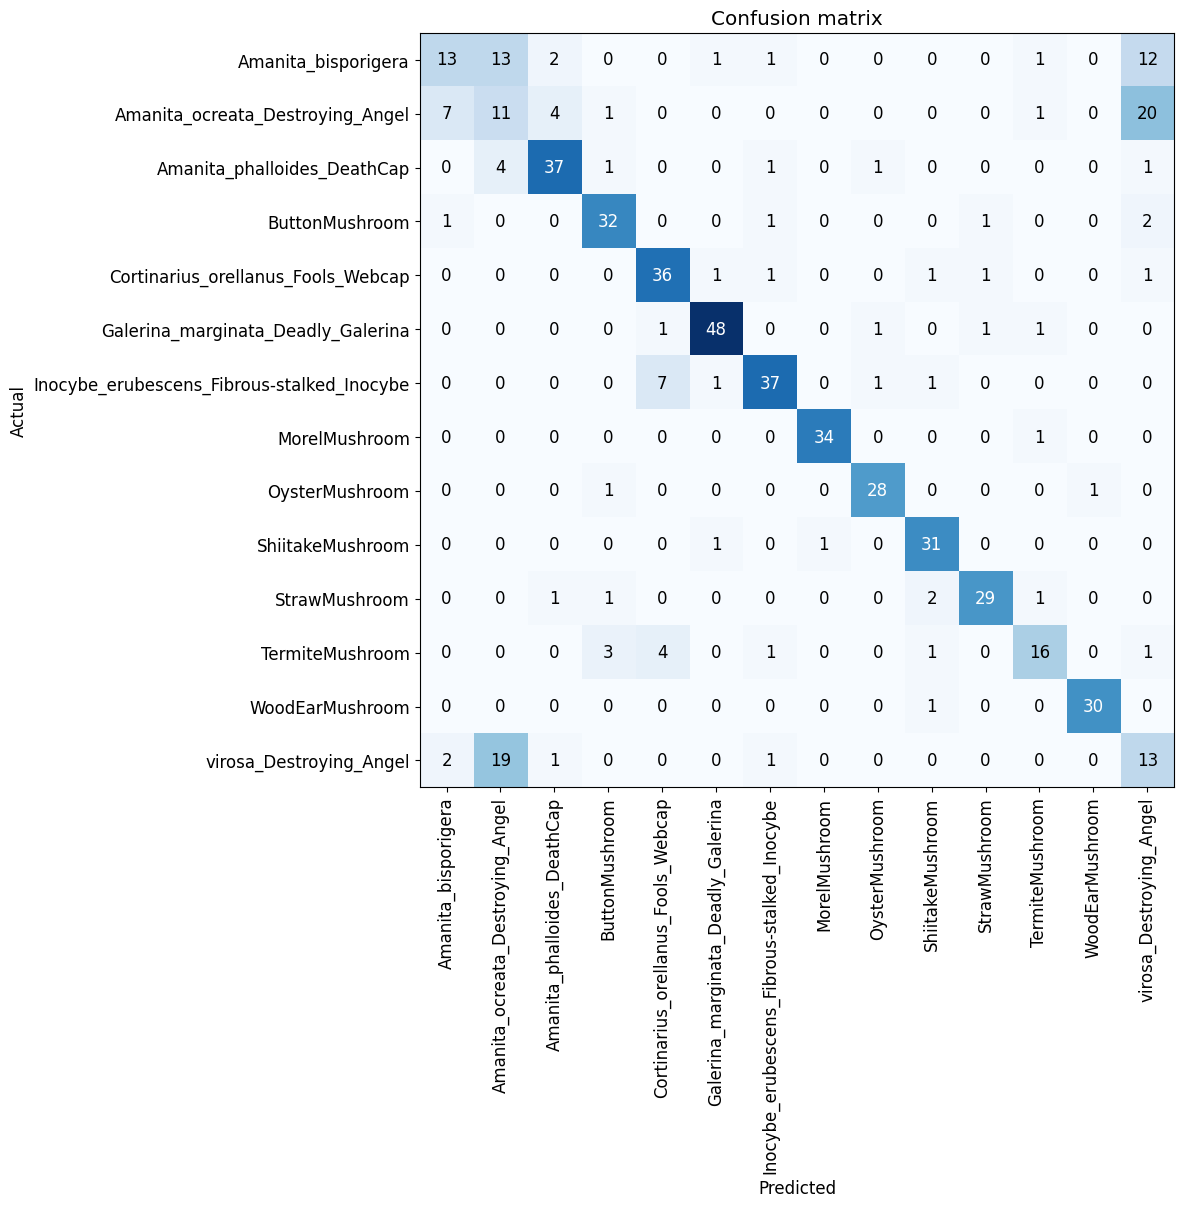

In [ ]:
interp.plot_confusion_matrix(figsize=(12, 12))

In [ ]:
def predict(img):
    # make prediction
    pred, pred_idx, pred_prob = learn.predict(img)
    print(pred,pred_prob[pred_idx])

In [ ]:
import time
start_time = time.time()
predict('/content/strawmushroom.jpg')
print("--- %s seconds ---" % (time.time() - start_time))

StrawMushroom tensor(0.5501)
--- 0.05530214309692383 seconds ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


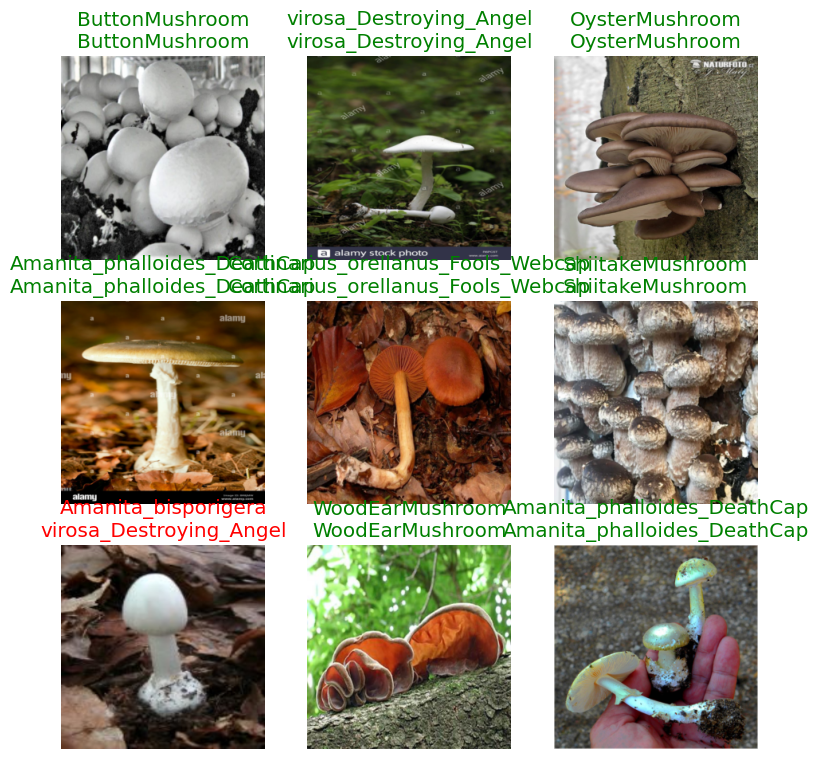

In [ ]:
learn.show_results()

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('resnet34.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')